Populating the interactive namespace from numpy and matplotlib
Shape of the image (657389,)


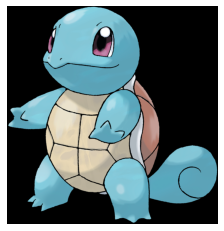

Shape of the image (540048,)


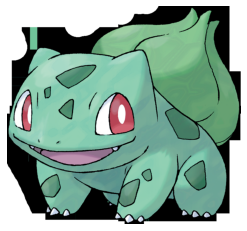

In [30]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf

%pylab inline

url_squirtle = r'https://www.pokepedia.fr/images/c/cc/Carapuce-RFVF.png'
resp = requests.get(url_squirtle, stream=True).raw
image_array_squirtle = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_squirtle.shape}')
image_squirtle = cv2.imdecode(image_array_squirtle, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_squirtle, cv2.COLOR_BGR2RGB))
plt.show()

url_bulbasaur = r'https://www.pokepedia.fr/images/e/ef/Bulbizarre-RFVF.png'
resp = requests.get(url_bulbasaur, stream=True).raw
image_array_bulbasaur = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_bulbasaur.shape}')
image_bulbasaur = cv2.imdecode(image_array_bulbasaur, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_bulbasaur, cv2.COLOR_BGR2RGB))
plt.show()

(40, 40, 3)
(40, 40)
000  000  000  000  000  000  000  000  000  000  000  000  000  000  255  255  255  255  255  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  
000  000  000  000  000  000  000  000  000  000  000  255  255  255  255  255  255  255  255  255  255  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  
000  000  000  000  000  000  000  000  000  000  255  255  255  255  255  255  255  255  255  255  255  255  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  
000  000  000  000  000  000  000  000  000  255  255  255  255  255  255  255  255  255  255  255  255  255  255  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  000  
000  000  000  000  000  000  000  000  000  255  255  255  255  255  255  255  255  000  255  255  255  255  255  255  000  000  000  000  000  000  000  000  000  000  000  

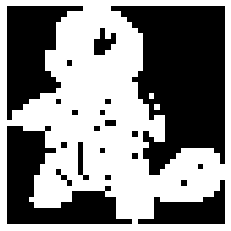

In [31]:
res = cv2.resize(image_squirtle , dsize=(40,40), interpolation=cv2.INTER_CUBIC)
print(res.shape)
res = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)
print(res.shape)
res = cv2.threshold(res, 127, 255, cv2.THRESH_BINARY)[1]
d = res
for row in range(0,40):
    for col in range(0,40):
        print('%03d ' %d[row][col],end=' ')
    print('')
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
#
#

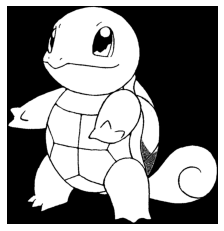

In [32]:
#Convert to black & white
img_bw = cv2.imdecode(image_array_squirtle, cv2.IMREAD_GRAYSCALE)
(thresh, img_bw) = cv2.threshold(img_bw, 127, 255, cv2.THRESH_BINARY)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))

[[-10   0  10]
 [-10   0  10]
 [-10   0  10]]


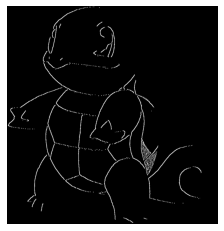

In [33]:
#defining a vertical edge detection kernel 
kernel = np.matrix([[-10,0,10],[-10,0,10],[-10,0,10]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[ 10  10  10]
 [  0   0   0]
 [-10 -10 -10]]


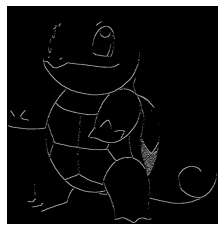

In [34]:
#defining an horizontal edge detection kernel 
kernel = np.matrix([[10,10,10],[0,0,0],[-10,-10,-10]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

In [35]:
#Import dataset (squirtles/bulbasaurs)
import pathlib
import os
data_dir = tf.keras.utils.get_file(
    "dataset5.zip",
    "https://github.com/Shidraw/projectIASquirtle/blob/main/dataset5.zip?raw=true",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/dataset')
print(data_dir)

/content/datasets/dataset


In [36]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

23


In [37]:
batch_size = 3
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 23 files belonging to 2 classes.
Using 19 files for training.
Found 23 files belonging to 2 classes.
Using 4 files for validation.
['bulbasaur', 'squirtle']


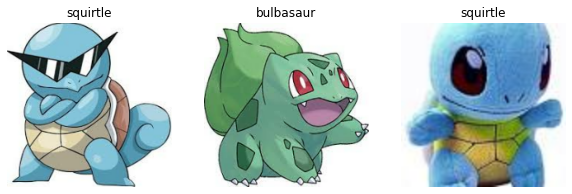

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [39]:
from tensorflow.keras import layers

# 2 => squirtle ou bulbasaur
num_classes = 2

#Sequential ~~ Container de convolutions
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(256,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    #Flatten => construire un vecteur à partir de la matrice de convolution
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    #softmax => probabilité entre les différentes classes
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],)

logdir="logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   embeddings_data=train_data)

#augmentation de l'entrainement via le nb d'epochs
model.fit( 
  train_data,
  validation_data=val_data,
  epochs=15,
  callbacks=[tensorboard_callback]
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


7/7 [==============================] - 2s 202ms/step - loss: 0.7334 - accuracy: 0.3684 - val_loss: 0.6158 - val_accuracy: 0.7500
Epoch 2/15
7/7 [==============================] - 1s 92ms/step - loss: 0.6983 - accuracy: 0.5789 - val_loss: 0.7004 - val_accuracy: 0.2500
Epoch 3/15
7/7 [==============================] - 1s 90ms/step - loss: 0.7294 - accuracy: 0.4737 - val_loss: 0.6633 - val_accuracy: 0.7500
Epoch 4/15
7/7 [==============================] - 1s 87ms/step - loss: 0.6799 - accuracy: 0.5789 - val_loss: 0.6031 - val_accuracy: 0.7500
Epoch 5/15
7/7 [==============================] - 1s 87ms/step - loss: 0.6720 - accuracy: 0.5789 - val_loss: 0.6161 - val_accuracy: 0.7500
Epoch 6/15
7/7 [==============================] - 1s 87ms/step - loss: 0.6484 - accuracy: 0.5789 - val_loss: 0.5080 - val_accuracy: 0.7500
Epoch 7/15
7/7 [==============================] - 1s 87ms/step - loss: 0.6131 - accuracy: 0.5789 - val_loss: 0.4182 - val_accuracy: 0.7500
Epoch 8/15
7/7 [=====================

In [40]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 197, 197, 256)     12544     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 98, 98, 256)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 95, 95, 128)       524416    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 47, 47, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 44, 44, 64)        131136    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 22, 22, 64)       

Saving squirtle10.jpg to squirtle10.jpg


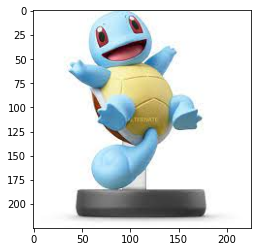

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[1]
[[0.01820628 0.98179364]]


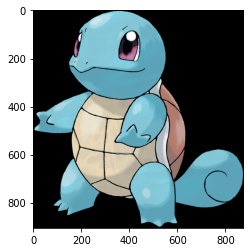

IT'S A SQUIRTLE !


In [43]:
from google.colab import files
file_to_predict = files.upload()
for file_ in file_to_predict:
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0) 
    res = model.predict_classes(img_to_predict)
    print(model.predict_classes(img_to_predict))
    print(model.predict(img_to_predict))
    if res == 1:
        plt.imshow(cv2.cvtColor(image_squirtle, cv2.COLOR_BGR2RGB))
        plt.show()
        print("IT'S A SQUIRTLE !")
    elif res == 0 :
        plt.imshow(cv2.cvtColor(image_bulbasaur, cv2.COLOR_BGR2RGB))
        plt.show()
        print("IT'S A BULBASAUR !")